Here we use combined light curves, where the PS1(gR) --SDSS(gr,ri)--> SDSS(gr)  (Tonry+2012) and PTF(grizy) --SDSS(gr)--> SDSS(griz)   (Ofek+2011).  And for CRTS I derived a correction CRTS(white) --SDSS(gi)--> SDSS(r) .

For all epochs where the SDSS g filter (real or synthetic) is available, I prepared the 'shifted' r : r_shift(t) = g(t) - mean(SDSS(g-r)) the mean is calculated earlier, based solely on the SDSS colors (since they are more trustworthy... ) . 


We fit each light curve for the MAP and EXP  solution for sigma, tau, fitting each section ( SDSS, SDSS+CRTS, SDSS+CRTS+PS1, SDSS+CRTS+PS1+PTF )... 

In [1]:
lcDir2 = '../data_products/SDSS-PTF-CRTS-PS1_2/' 

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import os
import pandas as pd 
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import  hstack
from astropy.table import  vstack
from astropy.table import Column
from astropy.table import join
import celerite
import modules as mod
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

Fitting routine : uses Celerite and some sub procedures that I wrote earlier 

In [62]:
def find_map_exp(lc):
    prior = 'Jeff1' # should have used Jeff1 , anyways ! 
    SF_inf = 0.2  # mags 
    sigma_in = SF_inf / np.sqrt(2)
    tau_in = 575 # days 
    sig_lims , tau_lims = [0.02,0.7], [1,5000]
    
    # find the MAP estimate 
    sigmaMAP, tauMAP,gp = mod.find_celerite_MAP(lc['mjd'],lc['mag'],lc['magerr'], 
                              sigma_in, tau_in, prior=prior,set_bounds=True, 
                              sig_lims=sig_lims, tau_lims=tau_lims ,verbose=False)

    # expectation from grid  
    Ngrid = 60  ; scale = 'log'
    sigma_grid, tau_grid = mod.make_grid(scale,sig_lims, tau_lims,Ngrid) 
    logP = mod.evaluate_logP(sigma_grid, tau_grid,lc['mag'],gp,prior)

    # find the expectation value 
    sigmaEXP, tauEXP = mod.find_expectation_value(logP, sigma_grid, 
                            tau_grid)

    return sigmaMAP, sigmaEXP, tauMAP, tauEXP  

Loop over files : fit the g-band data ... 

In [102]:
lcs = os.listdir(lcDir2)

resMAP = {'g':{'t1':np.zeros_like(lcs, dtype=float), 
          't2':np.zeros_like(lcs, dtype=float), 
          't3':np.zeros_like(lcs, dtype=float), 
          't4':np.zeros_like(lcs, dtype=float),
          's1':np.zeros_like(lcs, dtype=float),
          's2':np.zeros_like(lcs, dtype=float),
          's3':np.zeros_like(lcs, dtype=float),
          's4':np.zeros_like(lcs, dtype=float),
              },
          'r':{'t1':np.zeros_like(lcs, dtype=float), 
          't2':np.zeros_like(lcs, dtype=float), 
          't3':np.zeros_like(lcs, dtype=float), 
          't4':np.zeros_like(lcs, dtype=float),
          's1':np.zeros_like(lcs, dtype=float),
          's2':np.zeros_like(lcs, dtype=float),
          's3':np.zeros_like(lcs, dtype=float),
          's4':np.zeros_like(lcs, dtype=float),
              } , 
          'rshift':{'t1':np.zeros_like(lcs, dtype=float), 
          't2':np.zeros_like(lcs, dtype=float), 
          't3':np.zeros_like(lcs, dtype=float), 
          't4':np.zeros_like(lcs, dtype=float),
          's1':np.zeros_like(lcs, dtype=float),
          's2':np.zeros_like(lcs, dtype=float),
          's3':np.zeros_like(lcs, dtype=float),
          's4':np.zeros_like(lcs, dtype=float),
                   }
         }
resEXP = {'g':{'t1':np.zeros_like(lcs, dtype=float), 
          't2':np.zeros_like(lcs, dtype=float), 
          't3':np.zeros_like(lcs, dtype=float), 
          't4':np.zeros_like(lcs, dtype=float),
          's1':np.zeros_like(lcs, dtype=float),
          's2':np.zeros_like(lcs, dtype=float),
          's3':np.zeros_like(lcs, dtype=float),
          's4':np.zeros_like(lcs, dtype=float),
              },
          'r':{'t1':np.zeros_like(lcs, dtype=float), 
          't2':np.zeros_like(lcs, dtype=float), 
          't3':np.zeros_like(lcs, dtype=float), 
          't4':np.zeros_like(lcs, dtype=float),
          's1':np.zeros_like(lcs, dtype=float),
          's2':np.zeros_like(lcs, dtype=float),
          's3':np.zeros_like(lcs, dtype=float),
          's4':np.zeros_like(lcs, dtype=float),
              } , 
          'rshift':{'t1':np.zeros_like(lcs, dtype=float), 
          't2':np.zeros_like(lcs, dtype=float), 
          't3':np.zeros_like(lcs, dtype=float), 
          't4':np.zeros_like(lcs, dtype=float),
          's1':np.zeros_like(lcs, dtype=float),
          's2':np.zeros_like(lcs, dtype=float),
          's3':np.zeros_like(lcs, dtype=float),
          's4':np.zeros_like(lcs, dtype=float),
                   }
         }

for i in range(len(lcs)):
    lcname = lcs[i]
    fname = lcDir2+lcname
    print(i, ' fitting ', fname) 

    lc = Table.read(fname, format='ascii')
    
    # Sample at cadences of SDSS,  SDSS+CRTS, SDSS+CRTS+PTF,  SDSS+CRTS+PTF+PS1

    #
    # fit g,r
    #
    for f in 'gr' : 
        print('Fitting all ', f, ' filter observations ')
        # only SDSS  :  t1 
        m1 = lc['survey'] == 'sdss'
        m2 = lc['filter'] == f
        m = m1*m2 
        #t = lc['mjd'][m] ; y= lc['mag'][m] ; yerr = lc['magerr'][m]
        lcfit = lc[['mjd', 'mag', 'magerr']][m]
        lcfit.sort('mjd')
        ##  do fitting and save tau, sigma MAP, EXP ... 
        sm,se, tm,te   = find_map_exp(lcfit)
        resMAP[f]['s1'][i], resEXP[f]['s1'][i] = sm,se
        resMAP[f]['t1'][i], resEXP[f]['t1'][i] = tm,te 

        # SDSS+CRTS : 
        m3 = lc['survey'] == 'crts'
        m4 = lc['filter2'] == f
        m = m3 * m4
        if np.sum(m) > 0 :
            lcfit2 = lc[['mjd', 'mag2', 'magerr']][m]
            lcfit2.rename_column('mag2', 'mag')
            lcfit = vstack([lcfit, lcfit2])
            lcfit.sort('mjd')
             ##  do fitting and save tau, sigma MAP, EXP ... 
            sm,se, tm,te   = find_map_exp(lcfit)
            resMAP[f]['s2'][i], resEXP[f]['s2'][i] = sm,se
            resMAP[f]['t2'][i], resEXP[f]['t2'][i] = tm,te 

        # SDSS+CRTS+PTF :  add  : t3 
        m5 = lc['survey'] == 'ptf'
        m6 = lc['filter2'] == f
        #  add lc['mjd'][m] ,   lc['mag2'][m]
        m = m5*m6
        if np.sum(m) > 0 :
            lcfit2 = lc[['mjd', 'mag2', 'magerr']][m]
            lcfit2.rename_column('mag2', 'mag')
            lcfit = vstack([lcfit, lcfit2])
            lcfit.sort('mjd')
            ##  do fitting and save tau, sigma MAP, EXP ... 
            sm,se, tm,te   = find_map_exp(lcfit)
            resMAP[f]['s3'][i], resEXP[f]['s3'][i] = sm,se
            resMAP[f]['t3'][i], resEXP[f]['t3'][i] = tm,te 

        # SDSS+CRTS+PTF+PS1  : add the following   : t4 
        m7 = lc['survey'] == 'ps1'
        m8 = lc['filter2'] == f
        m = m7*m8
        if np.sum(m) > 0 :
            lcfit2 = lc[['mjd', 'mag2', 'magerr']][m]
            lcfit2.rename_column('mag2', 'mag')
            lcfit = vstack([lcfit, lcfit2])
            lcfit.sort('mjd')
            ##  do fitting and save tau, sigma MAP, EXP ... 
            sm,se, tm,te   = find_map_exp(lcfit)
            resMAP[f]['s4'][i], resEXP[f]['s4'][i] = sm,se
            resMAP[f]['t4'][i], resEXP[f]['t4'][i] = tm,te 
            
    #
    # fit r-shift : r and g shifted onto r .... 
    #
    f = 'rshift'
    print('Fitting all ', f, ' observations ')
    # 1: only SDSS : true r 
    m1 = lc['survey'] == 'sdss'
    m2 = lc['filter'] == 'r'
    # add lc['mjd'][m] , lc['mag'][m]
    m = m1*m2 
    lcfit = lc[['mjd', 'mag', 'magerr']][m]
    lcfit.sort('mjd')
    ##  do fitting and save tau, sigma MAP, EXP ... 
    sm,se, tm,te   = find_map_exp(lcfit)
    resMAP[f]['s1'][i], resEXP[f]['s1'][i] = sm,se
    resMAP[f]['t1'][i], resEXP[f]['t1'][i] = tm,te 
    
    # 2: SDSS+CRTS : adding SDSS_synth_r 
    m3 = lc['survey'] == 'crts'
    m4 = lc['filter2'] == 'r'
    #  add lc['mjd'][m] ,   lc['mag2'][m]
    m = m3 * m4
    if np.sum(m) > 0 :
        lcfit2 = lc[['mjd', 'mag2', 'magerr']][m]
        lcfit2.rename_column('mag2', 'mag')
        lcfit = vstack([lcfit, lcfit2])
        lcfit.sort('mjd')
         ##  do fitting and save tau, sigma MAP, EXP ... 
        sm,se, tm,te   = find_map_exp(lcfit)
        resMAP[f]['s2'][i], resEXP[f]['s2'][i] = sm,se
        resMAP[f]['t2'][i], resEXP[f]['t2'][i] = tm,te 
        
    # 3: SDSS+CRTS+PTF :  add SDSS_synth_r, 
    m5 = lc['survey'] == 'ptf'
    m6 = lc['filter2'] == 'r'
    #  add lc['mjd'][m] ,   lc['mag2'][m]
    m = m5*m6
    if np.sum(m) > 0 :
        lcfit2 = lc[['mjd', 'mag2', 'magerr']][m]
        lcfit2.rename_column('mag2', 'mag')
        lcfit = vstack([lcfit, lcfit2])
        
    m5a = lc['survey'] =='ptf'
    m6a = lc['filter2'] == 'g' # shifted r was calculated only for PTF g
    # add lc['mjd'][m],  lc['rmag'][m] 
    m = m5a*m6a
    if np.sum(m) > 0 : 
        lcfit2 = lc[['mjd', 'rmag', 'magerr']][m]
        lcfit2.rename_column('rmag', 'mag')
        lcfit = vstack([lcfit, lcfit2])
    
    # fit if either were nonzero ... 
    if (np.sum(m5*m6) > 0 ) | (np.sum(m5a*m6a) > 0 ) : 
        lcfit.sort('mjd')
        ##  do fitting and save tau, sigma MAP, EXP ... 
        sm,se, tm,te   = find_map_exp(lcfit)
        resMAP[f]['s3'][i], resEXP[f]['s3'][i] = sm,se
        resMAP[f]['t3'][i], resEXP[f]['t3'][i] = tm,te 
        

    # 4: SDSS+CRTS+PTF+PS1  : add the following 
    m7 = lc['survey'] == 'ps1'
    m8 = lc['filter2'] == 'r'
    #  add lc['mjd'][m] ,   lc['mag2'][m]
    m = m7*m8
    if np.sum(m) > 0 :
        lcfit2 = lc[['mjd', 'mag2', 'magerr']][m]
        lcfit2.rename_column('mag2', 'mag')
        lcfit = vstack([lcfit, lcfit2])
    
    m7a = lc['survey'] == 'ps1'
    m8a = lc['filter2'] == 'g'
    m = m7a*m8a
    # add lc['mjd'][m] , lc['rmag'][m]
    if np.sum(m) > 0 :
        lcfit2 = lc[['mjd', 'rmag', 'magerr']][m]
        lcfit2.rename_column('rmag', 'mag')
        lcfit = vstack([lcfit, lcfit2])
    
    if (np.sum(m7*m8) > 0) | (np.sum(m7a*m8a) > 0):
        lcfit.sort('mjd')
        ##  do fitting and save tau, sigma MAP, EXP ... 
        sm,se, tm,te   = find_map_exp(lcfit)
        resMAP[f]['s4'][i], resEXP[f]['s4'][i] = sm,se
        resMAP[f]['t4'][i], resEXP[f]['t4'][i] = tm,te 
        
        
print('Done')

0  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1441903.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/908716.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/100520.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3759755.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
4  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/505877.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
5  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/248292.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:189: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:194: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


Fitting all  r  filter observations 
Fitting all  rshift  observations 
43  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3989384.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
44  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1298222.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
45  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1875034.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
46  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1025069.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
47  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2485578.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
48  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1968059.txt
Fitting all

Fitting all  rshift  observations 
91  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/672676.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
92  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/125207.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
93  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/206300.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
94  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/367098.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
95  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/4091892.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
96  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1508126.txt
Fitting all  g  filter observations 
Fitting all  r 

Fitting all  rshift  observations 
139  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2507619.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
140  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/678561.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
141  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3913866.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
142  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/4107774.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
143  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1376099.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
144  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1298154.txt
Fitting all  g  filter observations 
Fittin

Fitting all  r  filter observations 
Fitting all  rshift  observations 
187  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/702756.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
188  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2464194.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
189  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3999791.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
190  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/207340.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
191  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1243220.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
192  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/673636.txt
Fitting 

Fitting all  r  filter observations 
Fitting all  rshift  observations 
235  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/392158.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
236  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/794906.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
237  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1421827.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
238  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1262562.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
239  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/906100.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
240  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3883051.txt
Fitting 

Fitting all  r  filter observations 
Fitting all  rshift  observations 
283  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2597579.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
284  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2022121.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
285  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3866220.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
286  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/499726.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
287  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1269806.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
288  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3078106.txt
Fittin

Fitting all  r  filter observations 
Fitting all  rshift  observations 
331  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2519208.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
332  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/111809.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
333  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/178667.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
334  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2966727.txt
Fitting all  g  filter observations 


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:189: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:194: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


Fitting all  r  filter observations 
Fitting all  rshift  observations 
335  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2587150.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
336  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/4084534.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
337  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1300734.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
338  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/388504.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
339  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/324188.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
340  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/4141654.txt
Fitting

Fitting all  r  filter observations 
Fitting all  rshift  observations 
383  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1242711.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
384  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/860454.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
385  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/392010.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
386  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1454328.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
387  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/101818.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
388  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/763578.txt
Fitting a

Fitting all  r  filter observations 
Fitting all  rshift  observations 
431  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1235200.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
432  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3966195.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
433  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/848441.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
434  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1678849.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
435  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1082200.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
436  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1903606.txt
Fittin

Fitting all  r  filter observations 
Fitting all  rshift  observations 
479  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/4128390.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
480  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/136734.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
481  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/4110169.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
482  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/311327.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
483  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/100286.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
484  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/21200.txt
Fitting al

Fitting all  r  filter observations 
Fitting all  rshift  observations 
527  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2135503.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
528  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/33348.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
529  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/271835.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
530  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/4529053.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
531  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2505637.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
532  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/135017.txt
Fitting a

Fitting all  r  filter observations 
Fitting all  rshift  observations 
575  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1243035.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
576  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2702902.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
577  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/404607.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
578  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1676279.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
579  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1959873.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
580  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2058843.txt
Fittin

Fitting all  r  filter observations 
Fitting all  rshift  observations 
623  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3998498.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
624  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/459716.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
625  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/580711.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
626  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/158833.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
627  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1678724.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
628  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/4007575.txt
Fitting 

Fitting all  r  filter observations 
Fitting all  rshift  observations 
671  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/709615.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
672  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/562018.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
673  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2200878.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
674  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3084631.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
675  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/696135.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
676  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/256858.txt
Fitting a

Fitting all  r  filter observations 
Fitting all  rshift  observations 
719  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3923964.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
720  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3279512.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
721  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1996018.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
722  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1851221.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
723  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/905620.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
724  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1262993.txt
Fittin

Fitting all  r  filter observations 
Fitting all  rshift  observations 
767  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3985033.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
768  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1053466.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
769  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1193656.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
770  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/239131.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
771  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2020866.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
772  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3536670.txt
Fittin

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:189: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:194: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


Fitting all  rshift  observations 
801  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3643041.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
802  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1319919.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
803  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1003721.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
804  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3146376.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
805  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2540801.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
806  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/308850.txt
Fitting all  g  filter observations 
Fittin

Fitting all  r  filter observations 
Fitting all  rshift  observations 
849  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/693840.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
850  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/4004643.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
851  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2031576.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
852  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1299660.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
853  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/248519.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
854  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3064104.txt
Fitting

Fitting all  r  filter observations 
Fitting all  rshift  observations 
897  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3903508.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
898  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1718360.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
899  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/137822.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
900  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1154443.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
901  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1896168.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
902  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1627190.txt
Fittin

Fitting all  r  filter observations 
Fitting all  rshift  observations 
945  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/286499.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
946  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/383293.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
947  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1057980.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
948  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2447561.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
949  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/4041069.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
950  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/406029.txt
Fitting 

Fitting all  r  filter observations 
Fitting all  rshift  observations 
993  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/921590.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
994  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3168879.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
995  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/738396.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
996  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3139388.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
997  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1450029.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
998  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2511257.txt
Fitting

Fitting all  r  filter observations 
Fitting all  rshift  observations 
1041  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1069338.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1042  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3988658.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1043  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1008739.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1044  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2049553.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1045  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3129824.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1046  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3909346.txt

Fitting all  r  filter observations 
Fitting all  rshift  observations 
1089  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3126901.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1090  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3682546.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1091  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1373125.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1092  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1568038.txt
Fitting all  g  filter observations 


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:189: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:194: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


Fitting all  r  filter observations 
Fitting all  rshift  observations 
1093  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1659513.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1094  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3647154.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1095  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/4112395.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1096  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1640042.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1097  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/417694.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1098  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1284591.txt


Fitting all  r  filter observations 
Fitting all  rshift  observations 
1141  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1002162.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1142  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3108544.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1143  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3964586.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1144  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/147308.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1145  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/4141849.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1146  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2612308.txt


Fitting all  r  filter observations 
Fitting all  rshift  observations 
1189  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1231935.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1190  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1798944.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1191  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1477285.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1192  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3908879.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1193  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2475129.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1194  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/502879.txt


Fitting all  r  filter observations 
Fitting all  rshift  observations 
1237  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1593840.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1238  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1278476.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1239  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/959548.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1240  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1412379.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1241  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/362495.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1242  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2523386.txt
F

Fitting all  r  filter observations 
Fitting all  rshift  observations 
1285  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2095994.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1286  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/4069679.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1287  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1906578.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1288  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1514287.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1289  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/648276.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1290  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1914168.txt


Fitting all  r  filter observations 
Fitting all  rshift  observations 
1333  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/952019.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1334  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1474375.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1335  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1094710.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1336  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1706997.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1337  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2615277.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1338  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/261215.txt
F

Fitting all  r  filter observations 
Fitting all  rshift  observations 
1381  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3129826.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1382  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/127950.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1383  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/337523.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1384  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1228453.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1385  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/892981.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1386  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3046239.txt
Fi

Fitting all  r  filter observations 
Fitting all  rshift  observations 
1429  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3141543.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1430  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2495800.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1431  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2579102.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1432  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1987463.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1433  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2009606.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1434  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1607134.txt

Fitting all  r  filter observations 
Fitting all  rshift  observations 
1477  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2612294.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1478  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/359774.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1479  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/7907462.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1480  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/20535.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1481  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3587308.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1482  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2106045.txt
Fi

Fitting all  r  filter observations 
Fitting all  rshift  observations 
1525  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2197833.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1526  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/317553.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1527  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3772715.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1528  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1513502.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1529  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2531595.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1530  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1664054.txt


Fitting all  r  filter observations 
Fitting all  rshift  observations 
1573  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2877405.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1574  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1343422.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1575  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/4129937.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1576  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/761418.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1577  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/4144517.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1578  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/718865.txt
F

Fitting all  r  filter observations 
Fitting all  rshift  observations 
1621  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1808731.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1622  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/522501.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1623  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/72837.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1624  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/983034.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1625  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1210960.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1626  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2009715.txt
Fit

Fitting all  r  filter observations 
Fitting all  rshift  observations 
1669  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/456257.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1670  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/130457.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1671  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/227805.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1672  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2566864.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1673  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/177734.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1674  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3124237.txt
Fit

Fitting all  r  filter observations 
Fitting all  rshift  observations 
1717  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/978735.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1718  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2521911.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1719  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/4055657.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1720  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/179533.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1721  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/410000.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1722  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2100282.txt
Fi

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:189: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:194: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


Fitting all  rshift  observations 
1745  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/4125561.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1746  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/808403.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1747  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/199216.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1748  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/209865.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1749  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/941771.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1750  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3994003.txt
Fitting all  g  filter observations 
Fit

Fitting all  r  filter observations 
Fitting all  rshift  observations 
1793  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/998945.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1794  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/4955607.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1795  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3035.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1796  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2702209.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1797  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2203492.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1798  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1688306.txt
Fit

Fitting all  r  filter observations 
Fitting all  rshift  observations 
1841  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1904080.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1842  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1995955.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1843  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/175731.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1844  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1296442.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1845  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/491654.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1846  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/106913.txt
Fi

Fitting all  r  filter observations 
Fitting all  rshift  observations 
1889  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3164955.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1890  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/4018385.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1891  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2042311.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1892  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3784436.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1893  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1697227.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1894  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3992665.txt

Fitting all  r  filter observations 
Fitting all  rshift  observations 
1937  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3167092.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1938  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2159255.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1939  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/951211.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1940  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1719783.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1941  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3123029.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1942  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/411323.txt
F

Fitting all  r  filter observations 
Fitting all  rshift  observations 
1985  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1275323.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1986  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3112790.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1987  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3662986.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1988  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/4046372.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1989  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1310034.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
1990  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1705802.txt

Fitting all  r  filter observations 
Fitting all  rshift  observations 
2033  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1489869.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2034  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1060596.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2035  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3984171.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2036  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/903145.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2037  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3937393.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2038  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/9321.txt
Fit

Fitting all  r  filter observations 
Fitting all  rshift  observations 
2081  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/328062.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2082  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/142217.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2083  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1678394.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2084  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1683640.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2085  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2607010.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2086  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/365604.txt
Fi

Fitting all  r  filter observations 
Fitting all  rshift  observations 
2129  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2532952.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2130  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3993828.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2131  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/570913.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2132  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/732554.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2133  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3973062.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2134  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3989870.txt
F

Fitting all  r  filter observations 
Fitting all  rshift  observations 
2177  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2622864.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2178  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/530072.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2179  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/272768.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2180  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2519692.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2181  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2125388.txt
Fitting all  g  filter observations 


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:189: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:194: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


Fitting all  r  filter observations 
Fitting all  rshift  observations 
2182  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/120082.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2183  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1996278.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2184  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3900305.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2185  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3825807.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2186  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/4038725.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2187  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/237546.txt
F

Fitting all  r  filter observations 
Fitting all  rshift  observations 
2230  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/206017.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2231  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/702904.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2232  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1623742.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2233  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1837460.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2234  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3710283.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2235  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2085856.txt
F

Fitting all  r  filter observations 
Fitting all  rshift  observations 
2278  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3066833.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2279  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1354098.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2280  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/328467.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2281  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2535379.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2282  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3741594.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2283  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/349264.txt
F

Fitting all  r  filter observations 
Fitting all  rshift  observations 
2326  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/4033315.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2327  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2223224.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2328  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/278734.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2329  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2758307.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2330  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3892302.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2331  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1209823.txt


Fitting all  r  filter observations 
Fitting all  rshift  observations 
2374  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/86234.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2375  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/277215.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2376  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/4088391.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2377  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1329339.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2378  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1273037.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2379  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/914148.txt
Fit

Fitting all  r  filter observations 
Fitting all  rshift  observations 
2422  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3157224.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2423  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3986001.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2424  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1448946.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2425  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1151986.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2426  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1327664.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2427  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1404594.txt

Fitting all  r  filter observations 
Fitting all  rshift  observations 
2470  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/158909.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2471  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1284120.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2472  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3924315.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2473  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1301664.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2474  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2580317.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2475  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2544433.txt


Fitting all  r  filter observations 
Fitting all  rshift  observations 
2518  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1585515.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2519  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2516639.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2520  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1766622.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2521  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/24646.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2522  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1640197.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2523  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1263591.txt
F

Fitting all  r  filter observations 
Fitting all  rshift  observations 
2566  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/4108344.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2567  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/227585.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2568  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/444245.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2569  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2482104.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2570  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1762518.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2571  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/194091.txt
Fi

Fitting all  r  filter observations 
Fitting all  rshift  observations 
2614  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3963102.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2615  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3058932.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2616  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/310117.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2617  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2519654.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2618  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1492445.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2619  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1599504.txt


Fitting all  r  filter observations 
Fitting all  rshift  observations 
2662  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/27945.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2663  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/952246.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2664  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2521335.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2665  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/215913.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2666  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2866391.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2667  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/548318.txt
Fitt

Fitting all  r  filter observations 
Fitting all  rshift  observations 
2710  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/918159.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2711  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/140558.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2712  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3095558.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2713  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/234507.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2714  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/4022235.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2715  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/326671.txt
Fit

Fitting all  r  filter observations 
Fitting all  rshift  observations 
2758  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/432265.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2759  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3916601.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2760  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3205911.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2761  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3800711.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2762  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/7911499.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2763  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/785259.txt
F

Fitting all  r  filter observations 
Fitting all  rshift  observations 
2806  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/948356.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2807  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1840982.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2808  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/4147081.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2809  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1349806.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2810  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2128910.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2811  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/519590.txt
F

Fitting all  r  filter observations 
Fitting all  rshift  observations 
2854  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3127908.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2855  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1310971.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2856  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1235273.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2857  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1006615.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2858  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/63081.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2859  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/926499.txt
Fi

Fitting all  r  filter observations 
Fitting all  rshift  observations 
2902  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3617110.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2903  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/592953.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2904  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1141012.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2905  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1471454.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2906  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1369732.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2907  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2018345.txt


Fitting all  r  filter observations 
Fitting all  rshift  observations 
2950  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2233018.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2951  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/928926.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2952  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3727819.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2953  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/946999.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2954  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/202909.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2955  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/32184.txt
Fitt

Fitting all  r  filter observations 
Fitting all  rshift  observations 
2998  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1111547.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
2999  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/4130357.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3000  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1782160.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3001  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/108734.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3002  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2011765.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3003  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/417391.txt
F

Fitting all  r  filter observations 
Fitting all  rshift  observations 
3046  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2034254.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3047  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3101878.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3048  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1032361.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3049  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/405018.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3050  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2506011.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3051  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2094790.txt


Fitting all  r  filter observations 
Fitting all  rshift  observations 
3094  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3925196.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3095  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/115002.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3096  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1329075.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3097  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/4133887.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3098  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3993224.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3099  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2549934.txt


Fitting all  r  filter observations 
Fitting all  rshift  observations 
3142  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/522129.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3143  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1952003.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3144  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1819566.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3145  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2604456.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3146  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/864318.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3147  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1066321.txt
F

Fitting all  r  filter observations 
Fitting all  rshift  observations 
3190  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/385250.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3191  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1633423.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3192  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1395761.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3193  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1898497.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3194  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/418100.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3195  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3120041.txt
F

Fitting all  r  filter observations 
Fitting all  rshift  observations 
3238  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3108717.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3239  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2482296.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3240  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1299803.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3241  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3897649.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3242  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/943557.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3243  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2611308.txt


Fitting all  r  filter observations 
Fitting all  rshift  observations 
3286  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1572145.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3287  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3935940.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3288  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2579554.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3289  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1091029.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3290  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1558974.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3291  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3056455.txt

Fitting all  r  filter observations 
Fitting all  rshift  observations 
3334  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1604123.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3335  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1006209.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3336  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/360170.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3337  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3054450.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3338  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/314829.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3339  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/3369769.txt
F

Fitting all  r  filter observations 
Fitting all  rshift  observations 
3382  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/4021530.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3383  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/1534500.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3384  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/261044.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3385  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2252824.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3386  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/81140.txt
Fitting all  g  filter observations 
Fitting all  r  filter observations 
Fitting all  rshift  observations 
3387  fitting  ../data_products/SDSS-PTF-CRTS-PS1_2/2398693.txt
Fi

KeyboardInterrupt: 

In [103]:
np.save('resMAP', resMAP)
np.save('resEXP', resEXP)

In [105]:

j = 10 
for i in '1234':
    print(resMAP['g']['t'+i][j])
print('\n')
for i in '1234':
    print(resMAP['r']['t'+i][j])
print('\n')
for i in '1234':
    print(resMAP['rshift']['t'+i][j])

25.509323373
0.0
0.0
31.9552553296


213.708243724
1852.13804023
465.956581437
1.0


213.708243724
1852.13804023
465.956581437
1.0


In [122]:
rmap = Table(data=[resMAP['r']['t1'],resMAP['r']['t2'],
                   resMAP['r']['t3'],resMAP['r']['t4']],
             names = ['t1','t2','t3','t4'])

gmap = Table(data=[resMAP['g']['t1'],resMAP['g']['t2'],
                   resMAP['g']['t3'],resMAP['g']['t4']],
             names = ['t1','t2','t3','t4'])

rshiftmap = Table(data=[resMAP['rshift']['t1'],resMAP['rshift']['t2'],
                   resMAP['rshift']['t3'],resMAP['rshift']['t4']],
             names = ['t1','t2','t3','t4'])

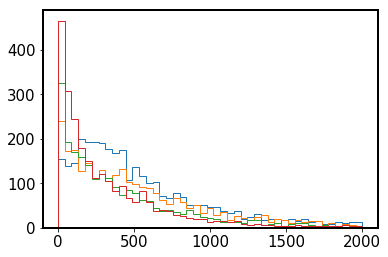

In [123]:
for i in '1234':
    m = rmap['t'+i] > 1 
    plt.hist(rmap['t'+i][m], histtype='step', bins=45, range=(0,2000))

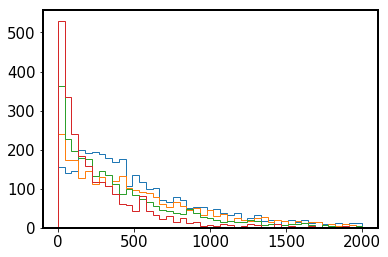

In [124]:
for i in '1234':
    m = rshiftmap['t'+i] > 1 
    plt.hist(rshiftmap['t'+i][m], histtype='step', bins=45, range=(0,2000))

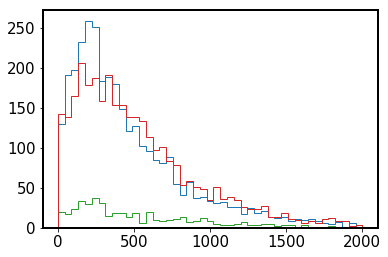

In [126]:
for i in '1234':
    m = gmap['t'+i] > 1 
    plt.hist(gmap['t'+i][m], histtype='step', bins=45, range=(0,2000))


??? what's going on ... 

In [127]:
rexp = Table(data=[resEXP['r']['t1'],resEXP['r']['t2'],
                   resEXP['r']['t3'],resEXP['r']['t4']],
             names = ['t1','t2','t3','t4'])

gexp = Table(data=[resEXP['g']['t1'],resEXP['g']['t2'],
                   resEXP['g']['t3'],resEXP['g']['t4']],
             names = ['t1','t2','t3','t4'])

rshiftexp = Table(data=[resEXP['rshift']['t1'],resEXP['rshift']['t2'],
                   resEXP['rshift']['t3'],resEXP['rshift']['t4']],
             names = ['t1','t2','t3','t4'])

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


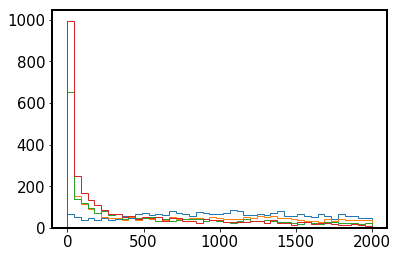

In [128]:
for i in '1234':
    m = rexp['t'+i] > 1 
    plt.hist(rexp['t'+i][m], histtype='step', bins=45, range=(0,2000))

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


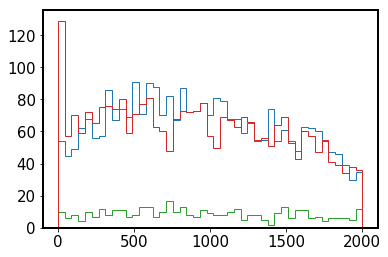

In [129]:
for i in '1234':
    m = gexp['t'+i] > 1 
    plt.hist(gexp['t'+i][m], histtype='step', bins=45, range=(0,2000))



/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


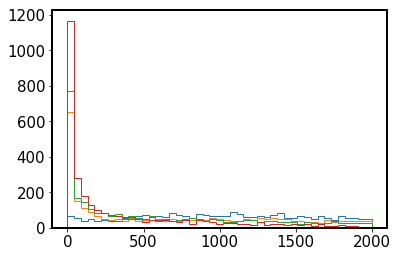

In [130]:
for i in '1234':
    m = rshiftexp['t'+i] > 1 
    plt.hist(rshiftexp['t'+i][m], histtype='step', bins=45, range=(0,2000))